In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from pandas_datareader import data as web
import datetime as dt
from statsmodels.tools import add_constant
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from scipy.stats import linregress
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# 📥 Data Sourcing & Cleaning

We fetch macroeconomic factors (from FRED & Yahoo Finance) and clean them to a common quarterly frequency. This includes Fed Funds rate, CPI, GDP growth, housing affordability, and REIT prices.  
Key functions: `fetch_macro_data()`, `clean_series()`


In [151]:
def clean_series(s):
    """Return 1-D Series, TZ-naive, month-end ('QE')."""
    if isinstance(s, pd.DataFrame) and s.shape[1] == 1:
        s = s.iloc[:, 0]
    s = s.dropna().copy()
    s.index = pd.to_datetime(s.index).tz_localize(None)
    return s.resample('QE').last()

def pmt(rate, nper, pv):
    """Level payment on amortizing loan."""
    return rate * pv / (1 - (1 + rate) ** -nper)

# ----------------------------------------------------------------------
# 1. Macro-factor fetcher  (start date adjustable)
# ----------------------------------------------------------------------
def fetch_macro_data(start='2005-01-01'):
    
    # Fed funds (anchor)
    #R (interest rate) and its first difference (dR)
    R   = clean_series(web.DataReader('FEDFUNDS', 'fred', start)['FEDFUNDS']) / 100
    dR       = R.diff()
    idx = R.index
    #GDP growth (YoY)
    GDP_YoY   = clean_series(web.DataReader('GDPC1','fred','2005-01-01')['GDPC1'].pct_change(1))
    GDP_YoY.fillna(method='ffill', inplace=True)
    
    # Unemployment rate (UNRATE)
    # Note: UNRATE is already seasonally adjusted in FRED.
    #       We resample to quarterly end (QE) for alignment.
    #       The data is in percent, so we divide by 100.
    #       We also calculate the first difference (dUNRATE).
    UN       = clean_series(web.DataReader('UNRATE','fred',start)['UNRATE'])/100
    UNRATE   = UN.reindex(idx)
    dUNRATE  = UNRATE.diff()

    #m2 growth (YoY) and first difference (dM2)
    # Note: M2SL is the M2 money stock, seasonally adjusted.
    # Dm2 is the first difference of M2.
    M2       = clean_series(web.DataReader('M2SL','fred',start)['M2SL']
                  .resample('QE').last()
                  .reindex(idx))
    M2YoY    = M2.pct_change(12, fill_method=None)
    dM2      = M2.pct_change(1,  fill_method=None)
    
    #Dow Jones Industrial Average (DJI) and its 3-period momentum (DJ_MOM3)

    dj        = clean_series(yf.download('^DJI', start=start,end  = pd.Timestamp.today())['Close']
                   .resample('QE').last()
                   .reindex(idx))
    DJ_MOM3   = dj.pct_change(3, fill_method=None)
    
    # wti (West Texas Intermediate crude oil) and VIX (Volatility Index)
    wti= clean_series(yf.download('WTI', start=start, end=pd.Timestamp.today())['Close']
                   .resample('QE').mean()
                   .reindex(idx))
    

    VIX = clean_series(yf.download('^VIX', start=start, end=pd.Timestamp.today())['Close']
                   .resample('QE').mean()
                   .reindex(idx))
    
    # Quarterly (3-period) moving average of VNQ (resampled to quarter-end for alignment)
    vnq_ma3 = yf.download('VNQ', start=start, end=pd.Timestamp.today(), auto_adjust=True)['Close'].rolling(window=3).mean()
    vnq_ma3 = clean_series(vnq_ma3).reindex(idx)

    # ── 3) Core factors ────────────────────────────────────────────────
    # Core CPI YoY
    CPI_lvl = clean_series(web.DataReader('CPILFESL', 'fred', start)['CPILFESL']).reindex(idx)
    CPI     = CPI_lvl.pct_change(12, fill_method=None); CPI.name = 'CPI'

    # Default premium (Baa – Aaa)
    BAA = clean_series(web.DataReader('BAA10Y', 'fred', start)['BAA10Y']).reindex(idx)
    AAA = clean_series(web.DataReader('AAA10Y', 'fred', start)['AAA10Y']).reindex(idx)
    DEF = (BAA - AAA); DEF.name = 'DEF'

    # 10y – 3m term premium
    DGS10 = clean_series(web.DataReader('DGS10', 'fred', start)['DGS10']).reindex(idx)
    TB3MS = clean_series(web.DataReader('TB3MS', 'fred', start)['TB3MS']).reindex(idx)
    TERM  = (DGS10 - TB3MS) / 100; TERM.name = 'TERM'

    # Dividend yield (S&P 500 price vs SPY dividends)
    sp   = clean_series(yf.download('^GSPC', start=start,end  = pd.Timestamp.today())['Close'].resample('QE').last()).reindex(idx)
    divs = clean_series(yf.Ticker('SPY').dividends.resample('QE').sum()).reindex(idx)
    if divs.isna().all():                                              # safety fallback
        divs = pd.Series(0.015, index=idx)
    DivY = (divs / sp); DivY.name = 'DivY'

    # Housing affordability components
    # ── 2.1  True housing-payment affordability ───────────────────────────────
    HPI   = clean_series(web.DataReader('MSPUS','fred',start)['MSPUS']).reindex(idx).ffill()
    INC   = clean_series(web.DataReader('MEHOINUSA646N','fred',start)['MEHOINUSA646N']).reindex(idx).ffill()
    # ── 2.2  Mortgage rate (30-yr fixed)
    # Note: FRED's MORTGAGE30US is not seasonally adjusted,
    #       so we use the last observation of each month.
    #       This is a common practice in macroeconomics.
    #       The data is in percent, so we divide by 100.
    MORTG = clean_series(web.DataReader('MORTGAGE30US','fred',start)['MORTGAGE30US']).reindex(idx).ffill() / 100
    MORTG.name = 'MORTG'

    loan_amt        = HPI * 0.80                       # 80 % LTV
    monthly_payment = pmt(MORTG / 12, 360, loan_amt)   # 30-yr amort
    monthly_income  = INC / 12
    AFFORD = (monthly_payment / monthly_income).rename('AFFORD')

    df = pd.DataFrame({'R':R, 'CPI':CPI, 'DEF':DEF, 'TERM':TERM,
                       'DivY':DivY, 'AFFORD':AFFORD, 'MORTG':MORTG,'GDP_YoY':GDP_YoY,'dUNRATE':dUNRATE,'M2YoY':M2YoY,'dM2':dM2,'dR':dR,'DJ_MOM3':DJ_MOM3,'DGS10':DGS10,'TB3MS':TB3MS,'WTI':wti,'VIX':VIX,'vnq_ma3':vnq_ma3}, index=idx)
    factors = df.shift(1).dropna(subset=['R','CPI','DEF','TERM'])      # keep rows w/ core data

    vnq_prices = clean_series(yf.download('VNQ', start=start, end=pd.Timestamp.today(), auto_adjust=True)['Close'])

    return factors, vnq_prices

factors, vnq_prices = fetch_macro_data('2005-01-01')
print("Factor window:", factors.first_valid_index(), "to", factors.last_valid_index())
print(factors.head())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Factor window: 2008-06-30 00:00:00 to 2025-06-30 00:00:00
                 R       CPI   DEF    TERM      DivY    AFFORD   MORTG  \
DATE                                                                     
2008-06-30  0.0261  0.071564  1.42  0.0219  0.000485  0.263355  0.0585   
2008-09-30  0.0200  0.073898  1.44  0.0213  0.000523  0.282375  0.0645   
2008-12-31  0.0181  0.076567  1.84  0.0272  0.000592  0.261684  0.0609   
2009-03-31  0.0016  0.069650  3.37  0.0222  0.000796  0.230565  0.0510   
2009-06-30  0.0018  0.068297  3.06  0.0250  0.000703  0.212077  0.0485   

             GDP_YoY  dUNRATE     M2YoY       dM2      dR   DJ_MOM3  DGS10  \
DATE                                                                         
2008-06-30 -0.004268    0.001  0.189489  0.024866 -0.0163 -0.085447   3.45   
2008-09-30  0.005954    0.005  0.189256  0.009635 -0.0061 -0.183196   3.99   
2008-12-31 -0.005253    0.005  0.190975  0.016593 -0.0019 -0.181997   3.85   
2009-03-31 -0.021890    0.012  0.

# 📊 Exploratory Analysis

Perform initial analysis:
- Correlation of macro factors with VNQ returns
- Stationarity checks (ADF test)
- Creation of Real Estate Premium (REP) based on debt-to-equity splits of REITs.


In [152]:
holdings = ('AMT', 'PLD', 'WELL', 'EQIX', 'DLR', 'SPG', 'PSA', 'O', 'CCI')
debt_to_equity = {}
for stock in holdings:
    yf_ticker = yf.Ticker(stock)
    info= yf_ticker.get_info()
    debt_to_equity[stock] = info.get('debtToEquity', None)
print(debt_to_equity)

{'AMT': 446.681, 'PLD': 56.643, 'WELL': 49.196, 'EQIX': 141.235, 'DLR': 79.552, 'SPG': 773.472, 'PSA': 97.458, 'O': 69.956, 'CCI': None}


In [153]:
debt_to_equity_series = pd.Series(debt_to_equity)
debt_to_equity_sorted = debt_to_equity_series.sort_values(ascending=False)
high_indebted = debt_to_equity_sorted[:len(debt_to_equity_sorted)//2]
low_indebted = debt_to_equity_sorted[len(debt_to_equity_sorted)//2:]
print("Top 50%:", high_indebted)
print("Bottom 50%:", low_indebted)

Top 50%: SPG     773.472
AMT     446.681
EQIX    141.235
PSA      97.458
dtype: float64
Bottom 50%: DLR     79.552
O       69.956
PLD     56.643
WELL    49.196
CCI        NaN
dtype: float64


In [154]:
# Download adjusted close prices
start_date = '2005-01-01'
high_prices = yf.download(list(high_indebted.keys()), start=start_date, end=dt.datetime.today())['Close'].resample('QE').last()
low_prices  = yf.download(list(low_indebted.keys()), start=start_date, end=dt.datetime.today())['Close'].resample('QE').last()
print(high_prices.first_valid_index(), "through", high_prices.last_valid_index())
print(low_prices.first_valid_index(), "through", low_prices.last_valid_index()) 
# Calculate Quaterly returns
high_returns = high_prices.pct_change().dropna()
low_returns  = low_prices.pct_change().dropna()

# Equally weighted portfolio returns
high_portfolio = high_returns.mean(axis=1)
low_portfolio  = low_returns.mean(axis=1)

# Real Estate Premium (REP)
REP = (high_portfolio - low_portfolio).rename('REP')

[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  5 of 5 completed

2005-03-31 00:00:00 through 2025-09-30 00:00:00
2005-03-31 00:00:00 through 2025-09-30 00:00:00


In [155]:
factors['REP'] = REP
factors.head()

,R,CPI,DEF,TERM,DivY,AFFORD,MORTG,GDP_YoY,dUNRATE,M2YoY,dM2,dR,DJ_MOM3,DGS10,TB3MS,WTI,VIX,vnq_ma3,REP
DATE,,,,,,,,,,,,,,,,,,,
2008-06-30,0.0261,0.071564,1.42,0.0219,0.000485,0.263355,0.0585,-0.004268,0.001,0.189489,0.024866,-0.0163,-0.085447,3.45,1.26,24.277323,26.120164,30.419369,0.054012
2008-09-30,0.0200,0.073898,1.44,0.0213,0.000523,0.282375,0.0645,0.005954,0.005,0.189256,0.009635,-0.0061,-0.183196,3.99,1.86,36.329386,20.672969,28.873039,-0.046998
2008-12-31,0.0181,0.076567,1.84,0.0272,0.000592,0.261684,0.0609,-0.005253,0.005,0.190975,0.016593,-0.0019,-0.181997,3.85,1.13,29.387499,25.073281,29.793101,0.025811
2009-03-31,0.0016,0.069650,3.37,0.0222,0.000796,0.230565,0.0510,-0.021890,0.012,0.226824,0.042209,-0.0165,-0.284313,2.25,0.03,11.952086,58.595937,17.853178,-0.008211
2009-06-30,0.0018,0.068297,3.06,0.0250,0.000703,0.212077,0.0485,-0.011349,0.014,0.238895,0.022145,0.0002,-0.329611,2.71,0.21,7.833174,45.000000,12.389279,0.072329


In [156]:
for fact in factors.columns:
    aligned = pd.concat([factors[fact], vnq_prices], axis=1).dropna()
    if len(aligned) > 0:
        r = np.corrcoef(aligned.iloc[:,0], aligned.iloc[:,1])[0,1]
        print(f"{fact}: R = {r:.3f}")
    else:
        print(f"{fact}: Not enough data to compute correlation.")

R: R = 0.517
CPI: R = 0.604
DEF: R = -0.539
TERM: R = -0.755
DivY: R = -0.718
AFFORD: R = 0.407
MORTG: R = 0.062
GDP_YoY: R = 0.190
dUNRATE: R = -0.155
M2YoY: R = 0.148
dM2: R = -0.049
dR: R = 0.292
DJ_MOM3: R = 0.278
DGS10: R = -0.043
TB3MS: R = 0.548
WTI: R = -0.660
VIX: R = -0.359
vnq_ma3: R = 0.967
REP: R = -0.157


## Stationarity Tests
Check ADF stats for all macro factors to avoid spurious regressions.


In [157]:

series_dict = {
    'VNQ_ret': vnq_prices.pct_change().dropna(),
    'R':       factors['R'],
    'CPI':     factors['CPI'],
    'DEF':     factors['DEF'],
    'TERM':    factors['TERM'],
    'DivY':    factors['DivY'],
    'AFFORD':  factors['AFFORD'],
    'MORTG':   factors['MORTG'],
    'GDP_YoY': factors['GDP_YoY'],
    'dUNRATE': factors['dUNRATE'],
    'M2YoY':   factors['M2YoY'],
    'dM2':     factors['dM2'],
    'dR':      factors['dR'],
    'DJ_MOM3': factors['DJ_MOM3'],
    'REP':     factors['REP']
}

# 2) Run ADF on each
results = []
for name, series in series_dict.items():
    clean = series.dropna()
    adf_stat, pvalue, used_lag, nobs, crit_vals, icbest = adfuller(clean, autolag='AIC')
    results.append({
        'Series':      name,
        'ADF Stat':    adf_stat,
        'p-value':     pvalue,
        'Lags Used':   used_lag,
        'nobs':        nobs,
        '1% Crit':     crit_vals['1%'],
        '5% Crit':     crit_vals['5%'],
        '10% Crit':    crit_vals['10%']
    })

adf_df = pd.DataFrame(results).set_index('Series')
print(adf_df[['ADF Stat','p-value','Lags Used','nobs','1% Crit','5% Crit','10% Crit']])
non_stationary = adf_df[adf_df['p-value'] > 0.05].index.tolist()

         ADF Stat       p-value  Lags Used  nobs   1% Crit   5% Crit  10% Crit
Series                                                                        
VNQ_ret -7.220463  2.117997e-10          1    80 -3.514869 -2.898409 -2.586439
R        0.031817  9.610855e-01          8    60 -3.544369 -2.911073 -2.593190
CPI     -0.374956  9.141970e-01         11    57 -3.550670 -2.913766 -2.594624
DEF     -3.103314  2.630894e-02          0    68 -3.530399 -2.905087 -2.590001
TERM    -0.276473  9.287710e-01          9    59 -3.546395 -2.911939 -2.593652
DivY     0.041923  9.618648e-01         10    58 -3.548494 -2.912837 -2.594129
AFFORD  -1.348231  6.068282e-01          0    68 -3.530399 -2.905087 -2.590001
MORTG   -1.836891  3.623061e-01          1    67 -3.531955 -2.905755 -2.590357
GDP_YoY -6.965926  8.915675e-10          1    67 -3.531955 -2.905755 -2.590357
dUNRATE -8.839748  1.680983e-14          0    68 -3.530399 -2.905087 -2.590001
M2YoY   -3.593075  5.894817e-03          4    64 -3.

In [158]:
non_stationary

['R', 'CPI', 'TERM', 'DivY', 'AFFORD', 'MORTG']

In [159]:
# Difference non-stationary factors
diff_factors = factors.diff().dropna()

# Replace original non-stationary columns
for col in non_stationary:
    if col in diff_factors:
        factors[col] = diff_factors[col]

### Recalculating ADF to make sure everything is stationary

In [160]:

series_dict = {
    'VNQ_ret': vnq_prices.pct_change().dropna(),
    'R':       factors['R'],
    'CPI':     factors['CPI'],
    'DEF':     factors['DEF'],
    'TERM':    factors['TERM'],
    'DivY':    factors['DivY'],
    'AFFORD':  factors['AFFORD'],
    'MORTG':   factors['MORTG'],
    'GDP_YoY': factors['GDP_YoY'],
    'dUNRATE': factors['dUNRATE'],
    'M2YoY':   factors['M2YoY'],
    'dM2':     factors['dM2'],
    'dR':      factors['dR'],
    'DJ_MOM3': factors['DJ_MOM3'],
    'REP':     factors['REP']
}

results = []
for name, series in series_dict.items():
    clean = series.dropna()
    adf_stat, pvalue, used_lag, nobs, crit_vals, icbest = adfuller(clean, autolag='AIC')
    results.append({
        'Series':      name,
        'ADF Stat':    adf_stat,
        'p-value':     pvalue,
        'Lags Used':   used_lag,
        'nobs':        nobs,
        '1% Crit':     crit_vals['1%'],
        '5% Crit':     crit_vals['5%'],
        '10% Crit':    crit_vals['10%']
    })

adf_df = pd.DataFrame(results).set_index('Series')
print(adf_df[['ADF Stat','p-value','Lags Used','nobs','1% Crit','5% Crit','10% Crit']])

         ADF Stat       p-value  Lags Used  nobs   1% Crit   5% Crit  10% Crit
Series                                                                        
VNQ_ret -7.220463  2.117997e-10          1    80 -3.514869 -2.898409 -2.586439
R       -3.580200  6.151039e-03          7    60 -3.544369 -2.911073 -2.593190
CPI     -2.877601  4.801540e-02         11    56 -3.552928 -2.914731 -2.595137
DEF     -3.103314  2.630894e-02          0    68 -3.530399 -2.905087 -2.590001
TERM    -4.413617  2.807876e-04          8    59 -3.546395 -2.911939 -2.593652
DivY    -4.998083  2.238780e-05          9    58 -3.548494 -2.912837 -2.594129
AFFORD  -7.801962  7.452103e-12          0    67 -3.531955 -2.905755 -2.590357
MORTG   -7.127803  3.582272e-10          0    67 -3.531955 -2.905755 -2.590357
GDP_YoY -6.965926  8.915675e-10          1    67 -3.531955 -2.905755 -2.590357
dUNRATE -8.839748  1.680983e-14          0    68 -3.530399 -2.905087 -2.590001
M2YoY   -3.593075  5.894817e-03          4    64 -3.

In [161]:
# returns aligned to factor index
ret = vnq_prices.pct_change().dropna().reindex(factors.index)

print("Factor rows :", len(factors))
print("Return rows :", len(ret))
print(factors.head(3))
print(ret.head(3))

Factor rows : 69
Return rows : 69
                 R       CPI   DEF    TERM      DivY    AFFORD   MORTG  \
DATE                                                                     
2008-06-30     NaN       NaN  1.42     NaN       NaN       NaN     NaN   
2008-09-30 -0.0061  0.002334  1.44 -0.0006  0.000037  0.019020  0.0060   
2008-12-31 -0.0019  0.002669  1.84  0.0059  0.000070 -0.020691 -0.0036   

             GDP_YoY  dUNRATE     M2YoY       dM2      dR   DJ_MOM3  DGS10  \
DATE                                                                         
2008-06-30 -0.004268    0.001  0.189489  0.024866 -0.0163 -0.085447   3.45   
2008-09-30  0.005954    0.005  0.189256  0.009635 -0.0061 -0.183196   3.99   
2008-12-31 -0.005253    0.005  0.190975  0.016593 -0.0019 -0.181997   3.85   

            TB3MS        WTI        VIX    vnq_ma3       REP  
DATE                                                          
2008-06-30   1.26  24.277323  26.120164  30.419369  0.054012  
2008-09-30   1.

## Granger causality - Quaterly

In [162]:
def pairwise_granger_all(df, target='VNQ_ret', maxlag=12, alpha=0.05):
    """
    Run pairwise Granger causality tests: all predictors → target
    - df: DataFrame with target + predictors
    - target: dependent variable (string)
    - maxlag: max lags to test
    - alpha: significance level for filtering
    """
    predictors = [col for col in df.columns]
    results = []

    for predictor in predictors:
        print(f"⏳ Testing if {predictor} → {target}")
        try:
            test_data = df[[target, predictor]].dropna()
            granger = grangercausalitytests(test_data, maxlag=maxlag, verbose=False)

            for lag, res in granger.items():
                f_pval = res[0]['ssr_ftest'][1]  # F-test p-value
                results.append({
                    'Predictor': predictor,
                    'Lag': lag,
                    'p-value': f_pval,
                    'Significant': f_pval < alpha
                })
        except Exception as e:
            print(f"⚠️ Skipping {predictor}: {e}")

    # Make summary DataFrame
    summary_df = pd.DataFrame(results)
    sig_df = summary_df[summary_df['Significant']].sort_values('p-value')
    return summary_df, sig_df


In [163]:
# Combine VNQ returns + macro factors
returns = vnq_prices.pct_change().dropna().rename('VNQ_ret')
data = pd.concat([returns.resample('QE').last().dropna(), factors.resample('QE').last().dropna()], axis=1).dropna()

# Run the pairwise Granger tests
all_results, sig_results = pairwise_granger_all(data, target='VNQ_ret', maxlag=12, alpha=0.05)

⏳ Testing if VNQ_ret → VNQ_ret
⏳ Testing if R → VNQ_ret
⏳ Testing if CPI → VNQ_ret
⏳ Testing if DEF → VNQ_ret
⏳ Testing if TERM → VNQ_ret
⏳ Testing if DivY → VNQ_ret
⏳ Testing if AFFORD → VNQ_ret
⏳ Testing if MORTG → VNQ_ret
⏳ Testing if GDP_YoY → VNQ_ret
⏳ Testing if dUNRATE → VNQ_ret
⏳ Testing if M2YoY → VNQ_ret
⏳ Testing if dM2 → VNQ_ret
⏳ Testing if dR → VNQ_ret
⏳ Testing if DJ_MOM3 → VNQ_ret
⏳ Testing if DGS10 → VNQ_ret
⏳ Testing if TB3MS → VNQ_ret
⏳ Testing if WTI → VNQ_ret
⏳ Testing if VIX → VNQ_ret
⏳ Testing if vnq_ma3 → VNQ_ret
⏳ Testing if REP → VNQ_ret


In [164]:
# Display results
print("\n All Granger Test Results:")
print(all_results)


 All Granger Test Results:
    Predictor  Lag   p-value  Significant
0     VNQ_ret    1  1.000000        False
1     VNQ_ret    2  1.000000        False
2     VNQ_ret    3  1.000000        False
3     VNQ_ret    4  1.000000        False
4     VNQ_ret    5  1.000000        False
..        ...  ...       ...          ...
235       REP    8  0.200027        False
236       REP    9  0.139812        False
237       REP   10  0.172067        False
238       REP   11  0.149484        False
239       REP   12  0.329174        False

[240 rows x 4 columns]


In [165]:
print("\n Significant Granger Results (p < 0.05):")
print(sig_results)


 Significant Granger Results (p < 0.05):
    Predictor  Lag   p-value  Significant
38        DEF    3  0.000812         True
113   dUNRATE    6  0.001513         True
206       VIX    3  0.001714         True
112   dUNRATE    5  0.003441         True
218   vnq_ma3    3  0.004032         True
101   GDP_YoY    6  0.004733         True
102   GDP_YoY    7  0.004733         True
115   dUNRATE    8  0.004807         True
114   dUNRATE    7  0.006163         True
205       VIX    2  0.007868         True
194       WTI    3  0.009013         True
103   GDP_YoY    8  0.010946         True
204       VIX    1  0.011335         True
37        DEF    2  0.012939         True
104   GDP_YoY    9  0.013451         True
219   vnq_ma3    4  0.014948         True
116   dUNRATE    9  0.016076         True
39        DEF    4  0.017128         True
147        dR    4  0.017515         True
15          R    4  0.017515         True
36        DEF    1  0.020895         True
192       WTI    1  0.022254      

In [166]:
cols=sig_results['Predictor'].unique()
print("\n Significant predictors:", cols)


 Significant predictors: ['DEF' 'dUNRATE' 'VIX' 'vnq_ma3' 'GDP_YoY' 'WTI' 'dR' 'R' 'CPI' 'REP'
 'dM2' 'AFFORD']


In [167]:
predictor_lags = sig_results.groupby('Predictor')['Lag'].apply(list).to_dict()
print(predictor_lags)

{'AFFORD': [2], 'CPI': [3, 4, 10], 'DEF': [3, 2, 4, 1], 'GDP_YoY': [6, 7, 8, 9, 11, 5, 10], 'R': [4], 'REP': [2], 'VIX': [3, 2, 1, 4], 'WTI': [3, 1], 'dM2': [11], 'dR': [4], 'dUNRATE': [6, 5, 8, 7, 9, 3, 10, 11, 12], 'vnq_ma3': [3, 4]}


In [168]:
lagged_factors = {}
for predictor in predictor_lags.keys():
    lags = predictor_lags[predictor]
    for lag in lags:
        lagged_factors[f'{predictor}_lag{lag}'] = factors[predictor].shift(lag)

lagged_factors = pd.DataFrame(lagged_factors).dropna()
ret = vnq_prices.pct_change().dropna().reindex(lagged_factors.index)

# Feature Selection & Modeling

Apply expanding-window OLS and Ridge regression to predict VNQ returns from lagged macro factors.
- Ridge regularization tunes alpha via cross-validation
- Evaluate predictions using correlation (R) and RMSE


## OLS

In [169]:
def expanding_ols_forecast(X, y, window=40):
    """Return Series of one-step-ahead forecasts."""
    pred = pd.Series(index=y.index, dtype=float)
    for i in range(window, len(y)):
        mod = OLS(y.iloc[:i], X.iloc[:i]).fit()
        pred.iloc[i] = mod.predict(X.iloc[i])
    return pred

In [170]:
pred = expanding_ols_forecast(add_constant(lagged_factors),ret, window=40)
pred.dropna(inplace=True)

In [171]:
def evaluate_preds(pred, y_true):
    mask = ~pred.isna()
    r = np.corrcoef(pred[mask], y_true[mask])[0,1]
    mse = mean_squared_error(y_true[mask], pred[mask])
    print(f"\n📊 Evaluation:")
    print(f"Correlation (R): {r:.3f}")
    print(f"RMSE: {np.sqrt(mse):.5f}")
    return r


📊 Evaluation:
Correlation (R): -0.090
RMSE: 1.03756


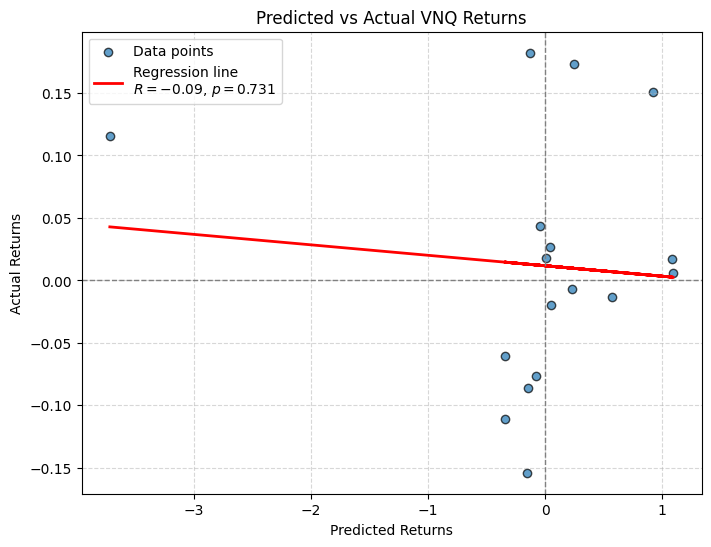

In [172]:

# Drop NaNs
mask = (~pred.isna()) & (~ret.isna())
x = pred[mask]
y = ret[mask]

r=evaluate_preds(x, y)

# Linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)
line = slope * x + intercept

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.7, edgecolor='k', label='Data points')
plt.plot(x, line, color='red', linewidth=2, label=f'Regression line\n$R={r_value:.2f}$, $p={p_value:.3f}$')
plt.title('Predicted vs Actual VNQ Returns')
plt.xlabel('Predicted Returns')
plt.ylabel('Actual Returns')
plt.axhline(0, color='grey', linestyle='--', linewidth=1)
plt.axvline(0, color='grey', linestyle='--', linewidth=1)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


### Filtering predictors

In [173]:
corr={}

for predictor in lagged_factors.columns:
    pred = expanding_ols_forecast(add_constant(lagged_factors[predictor]),ret, window=40)
    print(f"Predictions for {predictor}:\n")
    r=evaluate_preds(pred, ret)
    if abs(r) > 0.28:
        corr[predictor] = r

Predictions for AFFORD_lag2:


📊 Evaluation:
Correlation (R): 0.245
RMSE: 0.09241
Predictions for CPI_lag3:


📊 Evaluation:
Correlation (R): 0.217
RMSE: 0.09612
Predictions for CPI_lag4:


📊 Evaluation:
Correlation (R): -0.259
RMSE: 0.10829
Predictions for CPI_lag10:


📊 Evaluation:
Correlation (R): -0.252
RMSE: 0.10370
Predictions for DEF_lag3:


📊 Evaluation:
Correlation (R): 0.076
RMSE: 0.09513
Predictions for DEF_lag2:


📊 Evaluation:
Correlation (R): -0.026
RMSE: 0.09581
Predictions for DEF_lag4:


📊 Evaluation:
Correlation (R): -0.391
RMSE: 0.10233
Predictions for DEF_lag1:


📊 Evaluation:
Correlation (R): -0.250
RMSE: 0.09685
Predictions for GDP_YoY_lag6:


📊 Evaluation:
Correlation (R): -0.381
RMSE: 0.11576
Predictions for GDP_YoY_lag7:


📊 Evaluation:
Correlation (R): -0.008
RMSE: 0.10697
Predictions for GDP_YoY_lag8:


📊 Evaluation:
Correlation (R): 0.257
RMSE: 0.09841
Predictions for GDP_YoY_lag9:


📊 Evaluation:
Correlation (R): -0.089
RMSE: 0.10621
Predictions for GDP_YoY_

In [174]:
print("Significant predictors with correlation > 0.3:")
for key in corr.keys():
    print(f"{key}: R = {corr[key]:.3f}") 

Significant predictors with correlation > 0.3:
DEF_lag4: R = -0.391
GDP_YoY_lag6: R = -0.381
REP_lag2: R = 0.337
VIX_lag4: R = -0.418
WTI_lag3: R = -0.404
WTI_lag1: R = -0.484
dM2_lag11: R = -0.457
dUNRATE_lag6: R = -0.398
dUNRATE_lag5: R = 0.421
dUNRATE_lag8: R = 0.370


### Re-Running the test with the filtered predictors

In [175]:
# Align indices of predictors and target (returns)
X = add_constant(lagged_factors[list(corr.keys())])
y = ret.reindex(X.index)
mask = ~y.isna()
pred_filtered = expanding_ols_forecast(X[mask], y[mask], window=40)

In [176]:
r=evaluate_preds(pred_filtered, ret)


📊 Evaluation:
Correlation (R): 0.431
RMSE: 0.14278


## Lasso

In [177]:
# ====================================================
# 2. Expanding-window ridge forecast
# ====================================================

def expanding_ridge_forecast_scaled(X, y, window=40,
                                    alphas=np.logspace(-3, 2, 30)):
    pred = pd.Series(index=y.index, dtype=float)
    for i in range(window, len(y)):
        X_train, y_train = X.iloc[:i], y.iloc[:i]

        scaler = StandardScaler().fit(X_train)
        X_train_z = scaler.transform(X_train)

        ridge = RidgeCV(alphas=np.logspace(-4,1,30), cv=5)
        ridge.fit(X_train_z, y_train)

        if i == window:
            print(f"α chosen on first window: {ridge.alpha_:.4f}")

        pred.iloc[i] = ridge.predict(scaler.transform(X.iloc[[i]]))[0]
    return pred


ridge_pred = expanding_ridge_forecast_scaled(lagged_factors[list(corr.keys())][mask], y[mask],window=42)
r = evaluate_preds(ridge_pred, ret)

α chosen on first window: 10.0000

📊 Evaluation:
Correlation (R): 0.526
RMSE: 0.09425


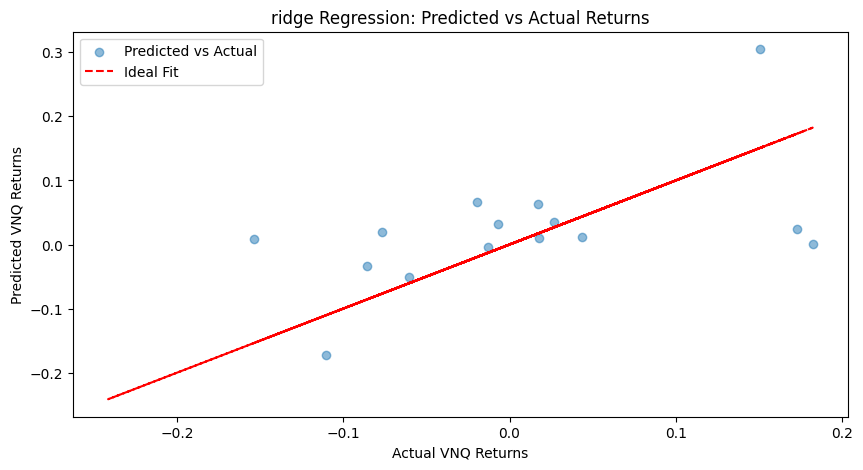

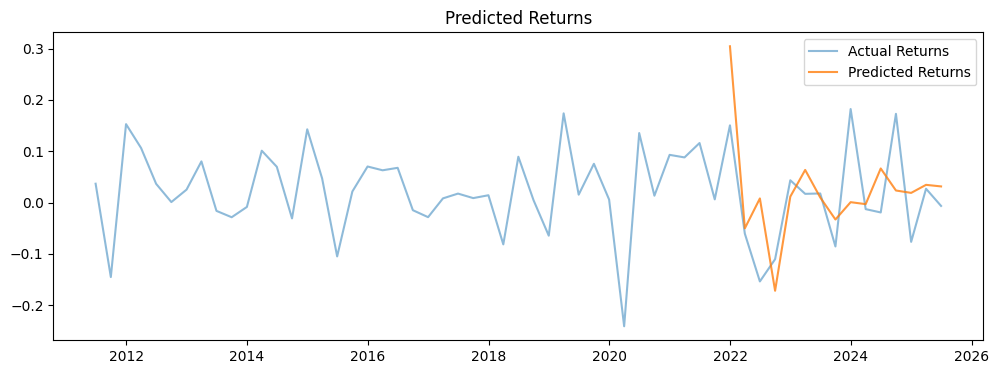

In [ ]:
# ====================================================
# 4. Plot predicted vs actual
# ====================================================
plt.figure(figsize=(10, 5))
plt.scatter(y, ridge_pred, alpha=0.5, label='Predicted vs Actual')
plt.plot(y, y, color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('Actual VNQ Returns')
plt.ylabel('Predicted VNQ Returns')
plt.title('ridge Regression: Predicted vs Actual Returns')
plt.legend()
plt.show()

# Plot signals over time
plt.figure(figsize=(12, 4))
plt.plot(ridge_pred.index, y, label='Actual Returns', alpha=0.5)
plt.plot(ridge_pred.index, ridge_pred, label='Predicted Returns', alpha=0.8)
plt.legend()
plt.title('Predicted Returns')
plt.show()

# 📐 Strategy Design

Create a threshold-based trading strategy:
- **Long VNQ** when residual > +σ
- **Short VNQ** when residual < -σ
- **Hold Treasury (DGS10)** during neutral signals


## Without Treasury Bonds

In [179]:
def calmar_ratio(returns):
    cumret = (1 + returns).cumprod()
    max_dd = ((cumret.cummax() - cumret) / cumret.cummax()).max()
    cagr = (1 + returns).prod()**(4 / len(returns)) - 1
    return cagr / max_dd if max_dd != 0 else np.nan

In [180]:
def performance_results(df_results):
    # Combine into DataFrame
    results_strat_df = pd.DataFrame(df_results).set_index('Threshold')

    # Normalize metrics to give equal weight
    # (Scale each to 0-1 range)
    normalized_df = results_strat_df.copy()
    for col in ['Calmar_s', 'Sharpe_s', 'CAGR_strat']:
        min_val = results_strat_df[col].min()
        max_val = results_strat_df[col].max()
        normalized_df[col] = (results_strat_df[col] - min_val) / (max_val - min_val)

    weights = {'Calmar_s': 0.4, 'Sharpe_s': 0.3, 'CAGR_strat': 0.3}
    normalized_df['Score'] = (
        normalized_df['Calmar_s'] * weights['Calmar_s'] +
        normalized_df['Sharpe_s'] * weights['Sharpe_s'] +
        normalized_df['CAGR_strat'] * weights['CAGR_strat']
    )

    # Find best performing threshold
    best_threshold = normalized_df['Score'].idxmax()
    best_stats = results_strat_df.loc[best_threshold]


    best_stats['CAGR_strat'] = f"{best_stats['CAGR_strat'] * 100:+.2f}%"
    best_stats['CAGR_VNQ'] = f"{best_stats['CAGR_VNQ'] * 100:+.2f}%"
    best_stats_display = pd.DataFrame(best_stats.drop(['strategy_cumret', 'vnq_cumret'])).T
    print(f"🏆 Best Performance at σ-threshold = {best_threshold:.2f} (based on combined Calmar, Sharpe, and CAGR)")
    display(best_stats_display)
    
    plt.figure(figsize=(10, 6))
    plt.plot(best_stats['strategy_cumret'].index, best_stats['strategy_cumret'], label='Strategy', linewidth=2)
    plt.plot(best_stats['vnq_cumret'].index, best_stats['vnq_cumret'], label='VNQ ETF', linewidth=2, linestyle='--')
    plt.title('Cumulative Returns: Strategy vs VNQ', fontsize=14)
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

In [181]:
def sharpe(q_ret, rf=0):
    """Annualised Sharpe on quarterly returns."""
    exc = q_ret - rf/4                       # rf optional
    return np.sqrt(4) * exc.mean() / exc.std(ddof=0)

🏆 Best Performance at σ-threshold = 0.50 (based on combined Calmar, Sharpe, and CAGR)


,CAGR_strat,CAGR_VNQ,Sharpe_s,Sharpe_VNQ,MaxDD_s,Trades,Calmar_s
0.5,+5.85%,+0.39%,0.52627,0.114657,0.064673,10,0.962605


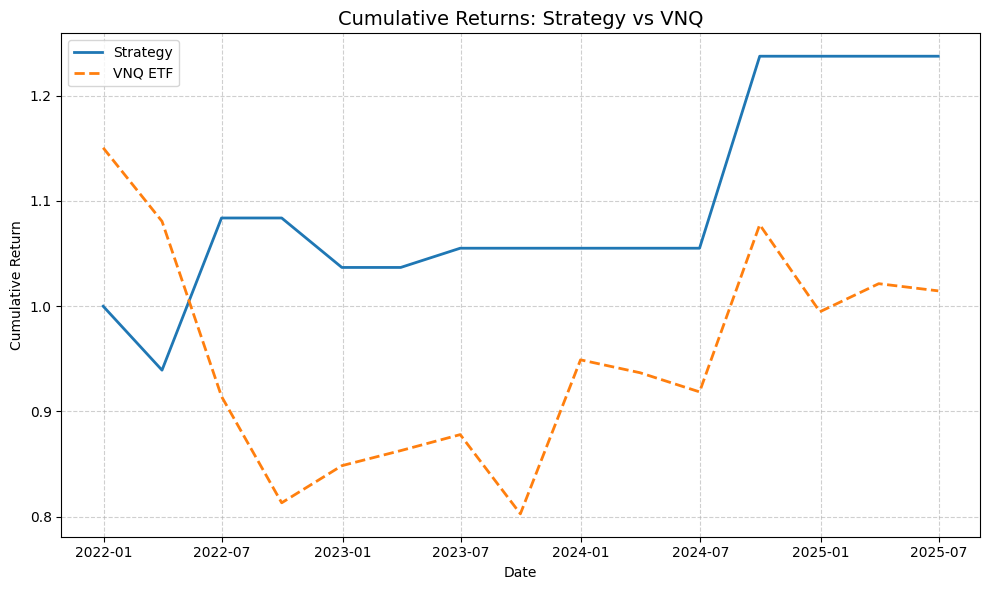

In [182]:

# ------------------------------------------------------------
# 0.   prerequisites
# ------------------------------------------------------------
mask      = ridge_pred.notna()           # quarterly VNQ returns
resid_std = ridge_pred[mask].std()           # fixed σ of residuals

def run_once(thr):
    """Build signal for sigma-threshold."""
    sig = ridge_pred.map(
        lambda x: 1  if x >  thr*resid_std
               else -1 if x < -thr*resid_std
               else  0
    )
    strat = (sig.shift(1) * ret).loc[mask]   # next-bar entry
    # === Cumulative Returns Plot ===

    # Calculate cumulative returns
    strategy_cumret = (1 + strat).cumprod()
    vnq_cumret = (1 + ret.loc[mask]).cumprod()

    # plt.figure(figsize=(10, 6))
    # plt.plot(strategy_cumret.index, strategy_cumret, label='Strategy', linewidth=2)
    # plt.plot(vnq_cumret.index, vnq_cumret, label='VNQ ETF', linewidth=2, linestyle='--')
    # plt.title('Cumulative Returns: Strategy vs VNQ', fontsize=14)
    # plt.xlabel('Date')
    # plt.ylabel('Cumulative Return')
    # plt.legend()
    # plt.grid(True, linestyle='--', alpha=0.6)
    # plt.tight_layout()
    # plt.show()

    out = {
        "CAGR_strat" : (1+strat).prod()**(4/len(strat))-1,
        "CAGR_VNQ"   : (1+ret.loc[mask]).prod()**(4/len(strat))-1,
        "Sharpe_s"   : sharpe(strat),
        "Sharpe_VNQ" : sharpe(ret.loc[mask]),
        "MaxDD_s"    : ((strat+1).cumprod().cummax() /
                        (strat+1).cumprod() - 1).max(),
        "Trades"     : int(sig.diff().abs().sum()),
        "Calmar_s": calmar_ratio(strat),
        "strategy_cumret": strategy_cumret,
        "vnq_cumret": vnq_cumret}

    return pd.Series(out)

# ------------------------------------------------------------
# 1.   grid-search over σ thresholds
# ------------------------------------------------------------
results_strat = []
for thr in [0.1,0.25,0.50, 0.60, 0.75, 1.00, 1.25]:
    res = run_once(thr)
    # print(f"\nσ-threshold  {thr:.2f}")
    #display(res)
    res['Threshold'] = thr
    results_strat.append(res)
performance_results(results_strat)

## With Treasury bonds

In [183]:
# Align mask index to factors['DGS10'] before indexing
aligned_mask = mask.reindex(factors['DGS10'].index, fill_value=False)
treasury_ret = factors['DGS10'].loc[aligned_mask] / 100 / 4  # approx. quarterly return

🏆 Best Performance at σ-threshold = 0.50 (based on combined Calmar, Sharpe, and CAGR)


,CAGR_strat,CAGR_VNQ,Sharpe_s,Sharpe_VNQ,MaxDD_s,Trades,Longs,Shorts,Neutral,Calmar_s
0.5,+8.51%,+0.39%,0.749634,0.114657,0.064673,10,3,2,52,1.401295


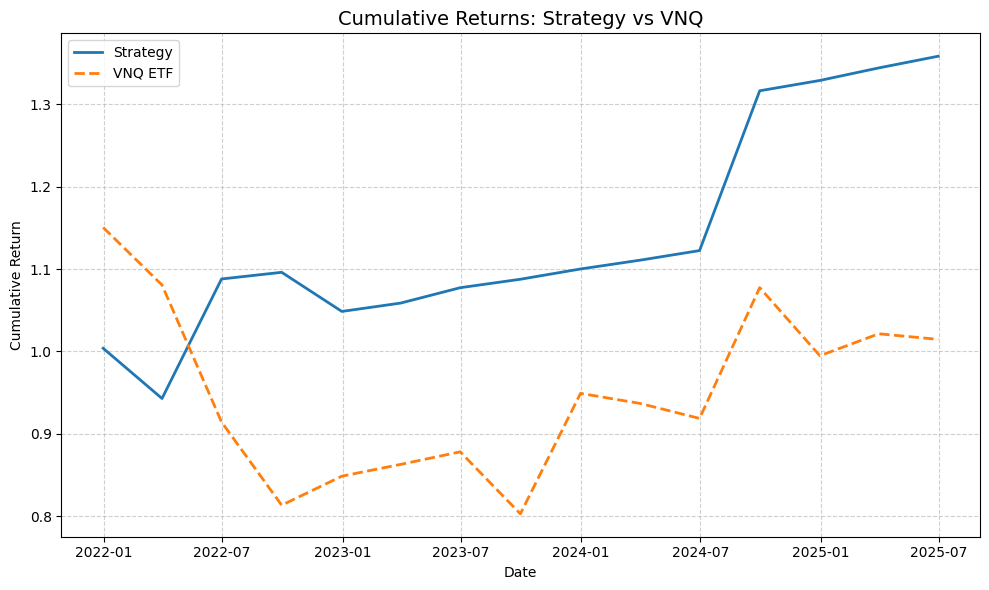

In [184]:
def run_once(thr):
    """Build signal for sigma-threshold.
    
    - Counts number of trades: long (1), short (-1), neutral (0)
    - Allocates to Treasury yield when signal == 0
    """
    # Build signal: 1 = long, -1 = short, 0 = neutral
    sig = ridge_pred.map(
        lambda x: 1  if x >  thr * resid_std
               else -1 if x < -thr * resid_std
               else 0
    )

    # Count trade types
    trade_counts = sig.value_counts().to_dict()
    longs = trade_counts.get(1, 0)
    shorts = trade_counts.get(-1, 0)
    neutrals = trade_counts.get(0, 0)

    # Strategy returns
    strat_ret = sig.shift(1).loc[mask] * ret.loc[mask]  # Long/Short returns
    strat_ret = strat_ret.where(sig.shift(1).loc[mask] != 0, treasury_ret)  # Treasury when neutral
    # Calculate cumulative returns
    strategy_cumret = (1 + strat_ret).cumprod()
    vnq_cumret = (1 + ret.loc[mask]).cumprod()
    # Performance stats
    out = {
        "CAGR_strat": (1 + strat_ret).prod()**(4 / len(strat_ret)) - 1,
        "CAGR_VNQ": (1 + ret.loc[mask]).prod()**(4 / len(strat_ret)) - 1,
        "Sharpe_s": sharpe(strat_ret),
        "Sharpe_VNQ": sharpe(ret.loc[mask]),
        "MaxDD_s": ((strat_ret + 1).cumprod().cummax() /
                    (strat_ret + 1).cumprod() - 1).max(),
        "Trades": int(sig.diff().abs().sum()),
        "Longs": longs,
        "Shorts": shorts,
        "Neutral": neutrals,
        "Calmar_s": calmar_ratio(strat_ret),
        "strategy_cumret": strategy_cumret,
        "vnq_cumret": vnq_cumret}

    # plt.figure(figsize=(10, 6))
    # plt.plot(strategy_cumret.index, strategy_cumret, label='Strategy (With Treasuries)', linewidth=2)
    # plt.plot(vnq_cumret.index, vnq_cumret, label='VNQ ETF', linewidth=2, linestyle='--')
    # plt.title('Cumulative Returns: Strategy vs VNQ', fontsize=14)
    # plt.xlabel('Date')
    # plt.ylabel('Cumulative Return')
    # plt.legend()
    # plt.grid(True, linestyle='--', alpha=0.6)
    # plt.tight_layout()
    # plt.show()

    # print(f"Trades: Long={longs}, Short={shorts}, Neutral={neutrals}")
    
    return pd.Series(out)
results_strat_tr = []
for thr in [0.1, 0.25, 0.50, 0.60, 0.75, 1.00, 1.25]:
    res = run_once(thr)
    res['Threshold'] = thr
    results_strat_tr.append(res)

performance_results(results_strat_tr)